### DOES NOT WORK AS INTENDED

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import cv2
import torchmetrics
from tqdm.notebook import tqdm

In [2]:
torch.__version__, torchvision.__version__

('2.0.0+cpu', '0.15.1+cpu')

In [3]:
import pandas as pd
annotation_path = "./road_condition_data/annotations.csv"
df = pd.read_csv(annotation_path)

df.head(10)

,Unnamed: 0,image_name,has_potholes,rating,is_pitched,has_cracks
0,0,1600.jpg,1,2,1,1
1,1,1601.jpg,1,2,1,1
2,2,1602.jpg,1,2,1,1
3,3,1610.jpg,0,3,1,0
4,4,1611.jpg,0,3,1,0
5,5,1612.jpg,0,3,1,0
6,6,1620.jpg,1,2,1,1
7,7,1621.jpg,1,2,1,1
8,8,1622.jpg,1,2,1,1
9,9,1630.jpg,1,2,1,1


In [4]:
shuffled_df = df.sample(frac=1)

shuffled_df.head(10)

,Unnamed: 0,image_name,has_potholes,rating,is_pitched,has_cracks
16286,16286,India_0097730.jpg,0,2,1,1
7390,7390,India_0040172.jpg,0,2,1,1
9436,9436,India_0075232.jpg,0,3,1,0
8031,8031,India_0050681.jpg,0,3,1,0
15093,15093,UnPavedRoad__5701.jpg,0,2,1,1
7701,7701,India_0045761.jpg,0,2,1,1
21521,21521,UngradedRoad_2220.jpg,0,2,1,1
4491,4491,IMG_20210221_1651411.jpg,1,2,1,0
13751,13751,UnPavedRoad__1620.jpg,0,1,0,1
19674,19674,SB__1161.jpg,0,3,1,0


In [5]:
# Preparing the dataset
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.classes = np.array(self.csv.drop(columns=['image_name', 'Unnamed: 0', 'rating']).columns)
        self.all_image_names = self.csv[:]['image_name']
        self.all_labels = np.array(self.csv.drop(columns=['image_name', 'rating']))
        self.train_ratio = int(0.8*len(self.csv))
        
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.ToTensor()
        ])
        
        if self.test == True:
            print(f"Number of testing images: {len(self.csv)-self.train_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio:])
            self.labels = list(self.all_labels[self.train_ratio:])
            self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        try:
            image = cv2.imread(f"./road_condition_data/full_dataset/{self.image_names[index]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = cv2.imread(f"./road_condition_data/full_dataset/PotHoles_3120.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image)
        targets = self.labels[index][1:4]
        
        return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))
              

In [6]:
torch.manual_seed(98)

train_dataset = ImageDataset(csv=df,
                             train=True,
                             test=False)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=32, 
                              shuffle=True)

test_dataset = ImageDataset(csv=df,
                           train=False,
                           test=True)
test_dataloader = DataLoader(test_dataset,
                            batch_size=32,
                            shuffle=True)

Number of training images: 17420
Number of testing images: 4356


In [7]:
class_names = train_dataset.classes
class_names

array(['has_potholes', 'is_pitched', 'has_cracks'], dtype=object)

In [8]:
def showSingleImage(img:torch.Tensor, lbl:torch.Tensor):
    title =  f"Pothole:{lbl[0]}|Pitch:{lbl[1]}|Crack:{lbl[2]}"
    plt.imshow(img.permute(1,2,0))
    plt.title(title)
    plt.axis(False)

C:\Users\aryal\AppData\Local\Temp\ipykernel_676\2232284418.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))


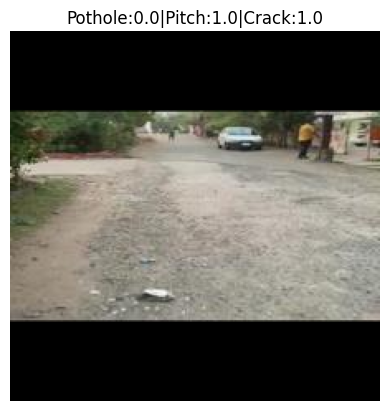

In [9]:
sample_image_batch, sample_label_batch = next(iter(test_dataloader))

sample_image = sample_image_batch[0]
sample_label = sample_label_batch[0]

showSingleImage(sample_image, sample_label)

In [10]:
def model(pretrained, requires_grad):
    model = models.resnet50(progress=True)
    
    for param in model.parameters():
        param.requires_grad = requires_grad
    
    model.fc = nn.Linear(2048, 3)
    return model

In [11]:
import torch
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, train_data, device="cpu"):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, (X, y) in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = X, y
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [12]:
def validate(model, dataloader, criterion, val_data, device="cpu"):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, (X,y) in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = X, y
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [13]:
model = model(pretrained=True, requires_grad=False)
# learning parameters
lr = 0.0001
epochs = 20
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [14]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, criterion, train_dataset
    )
    valid_epoch_loss = validate(
        model, test_dataloader, criterion, test_dataset
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 20
Training


  0%|          | 0/544 [00:00<?, ?it/s]C:\Users\aryal\AppData\Local\Temp\ipykernel_676\2232284418.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))
545it [26:00,  2.86s/it]                         


Validating


137it [05:51,  2.57s/it]                         


Train Loss: 0.5528
Val Loss: 0.6254
Epoch 2 of 20
Training


545it [26:01,  2.87s/it]                         


Validating


137it [05:38,  2.47s/it]                         


Train Loss: 0.5334
Val Loss: 0.6148
Epoch 3 of 20
Training


545it [25:32,  2.81s/it]                         


Validating


137it [05:38,  2.47s/it]                         


Train Loss: 0.5246
Val Loss: 0.6143
Epoch 4 of 20
Training


545it [25:29,  2.81s/it]                         


Validating


137it [05:44,  2.51s/it]                         


Train Loss: 0.5187
Val Loss: 0.6078
Epoch 5 of 20
Training


545it [26:13,  2.89s/it]                         


Validating


137it [05:45,  2.52s/it]                         


Train Loss: 0.5136
Val Loss: 0.6261
Epoch 6 of 20
Training


545it [26:10,  2.88s/it]                         


Validating


137it [05:46,  2.53s/it]                         


Train Loss: 0.5120
Val Loss: 0.6060
Epoch 7 of 20
Training


545it [26:10,  2.88s/it]                         


Validating


137it [05:44,  2.52s/it]                         


Train Loss: 0.5080
Val Loss: 0.6054
Epoch 8 of 20
Training


545it [26:12,  2.89s/it]                         


Validating


137it [05:46,  2.53s/it]                         


Train Loss: 0.5060
Val Loss: 0.6088
Epoch 9 of 20
Training


545it [26:15,  2.89s/it]                         


Validating


137it [05:46,  2.53s/it]                         


Train Loss: 0.5066
Val Loss: 0.6216
Epoch 10 of 20
Training


545it [26:08,  2.88s/it]                         


Validating


137it [05:44,  2.52s/it]                         


Train Loss: 0.5027
Val Loss: 0.6501
Epoch 11 of 20
Training


  6%|▌         | 32/544 [01:34<25:18,  2.97s/it]


KeyboardInterrupt: 

In [15]:
train_loss

[0.5527939337109207,
 0.5333643238478845,
 0.5246237471016175,
 0.5186609766898899,
 0.5136442137967556,
 0.5120017096536968,
 0.5080457739326932,
 0.5059968135225663,
 0.5066436928346616,
 0.5027295989180923]